In [311]:
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  datetime import date, timedelta

In [312]:
date_now = str(date.today() - timedelta(days=1))
df_apple_to_csv = yf.download("AAPL", start="2020-01-01", end=date_now)
df_microsoft_to_csv = yf.download("MSFT", start="2020-01-01", end=date_now)
df_amazon_to_csv = yf.download("AMZN", start="2020-01-01", end=date_now)
df_nvidia_to_csv = yf.download("NVDA", start="2020-01-01", end=date_now)


apple_path = 'datasets/apple.csv'
microsoft_path = 'datasets/microsoft.csv'
amazon_path = 'datasets/amazon.csv'
nvidia_path = 'datasets/nvidia.csv'

df_apple_to_csv.to_csv(apple_path)
df_microsoft_to_csv.to_csv(microsoft_path)
df_amazon_to_csv.to_csv(amazon_path)
df_nvidia_to_csv.to_csv(nvidia_path)

df_apple = pd.read_csv(apple_path)
df_microsoft = pd.read_csv(microsoft_path)
df_amazon = pd.read_csv(amazon_path)
df_nvidia = pd.read_csv(nvidia_path)

C:\Users\acer\AppData\Local\Temp\ipykernel_13964\2667087305.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_apple_to_csv = yf.download("AAPL", start="2020-01-01", end=date_now)
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_13964\2667087305.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_microsoft_to_csv = yf.download("MSFT", start="2020-01-01", end=date_now)
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_13964\2667087305.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_amazon_to_csv = yf.download("AMZN", start="2020-01-01", end=date_now)
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_13964\2667087305.py:5: FutureWarning: YF.download() has changed argument auto_adjust defaul

In [313]:
df_apple['Date'] = df_apple['Price']
df_apple = df_apple.drop(index=[0,1], columns='Price')

df_microsoft['Date'] = df_microsoft['Price']
df_microsoft = df_microsoft.drop(index=[0,1], columns='Price')

df_amazon['Date'] = df_amazon['Price']
df_amazon = df_amazon.drop(index=[0,1], columns='Price')

df_nvidia['Date'] = df_nvidia['Price']
df_nvidia = df_nvidia.drop(index=[0,1], columns='Price')

In [314]:
#INITIAL
dfs = [df_apple, df_amazon, df_microsoft, df_nvidia]
window = 14
short_period = 12
long_period = 26
signal_line_period = 9
stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA']

In [315]:
#CONVERTING TO CORRECT FEATURE TYPES
def convert_type(df):
    df['Close'] = df['Close'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Volume'] = df['Volume'].astype(int)
    df['Date'] = pd.to_datetime(df['Date'])

In [316]:
#FEATURE ENGINEERING
def engineer_features(df):
    df['Price Change'] = df['Close'].diff().fillna(0)

    df['Gain'] = df.loc[df['Price Change'] > 0, 'Price Change']
    df['Loss'] = -df.loc[df['Price Change'] < 0, 'Price Change']

    df['Gain'] = df['Gain'].fillna(0)
    df['Loss'] = df['Loss'].fillna(0)

    df['Average Gain'] = df['Gain'].rolling(window=window).mean().fillna(0)
    df['Average Loss'] = df['Loss'].rolling(window=window).mean().fillna(0)

    df['RS'] = df['Average Gain'] / df['Average Loss']

    df['RSI'] = 100 - (100 / (1 + df['RS']))

    df['Short EMA'] = df['Close'].ewm(span=short_period,adjust=False).mean()
    df['Long EMA'] = df['Close'].ewm(span=long_period, adjust=False).mean()

    df['MACD'] = df['Short EMA'] - df['Long EMA']

    df['Signal Line'] = df['MACD'].ewm(span=signal_line_period, adjust=False).mean()
    
    df['MACD Histogram'] = df['MACD'] - df['Signal Line']
    
    df['Year'] = df['Date'].dt.year
    df['Week'] = df['Date'].dt.weekday
    
    df['Year-Month'] = df['Date'].dt.to_period('M').astype(str)
    #df['Week']
    
    return df

In [317]:
#DROPPING NULL AND UNIMPORTANT COLUMNS/ROWS
def drop_features_and_na(df):
    df = df.drop(columns=['Gain', 'Loss'])
    df = df.dropna()
    return df

In [318]:
#PRINTING SEABORN PLOTS
def print_dmy_plots(df, stock):
    #1W
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df.loc[len(df) - 7::, ['Date','Close']], x='Date', y='Close', errorbar=None)
    plt.title(f'1 Week for {stock}')
    plt.show()
    
    #1M
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df.loc[len(df) - 31::, ['Date','Close']], x='Date', y='Close', errorbar=None)
    plt.title(f'1 Month for {stock}')
    plt.show()
    
    #3M
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df.loc[len(df) - (31 * 3)::, ['Date','Close']], x='Date', y='Close', errorbar=None)
    plt.title(f'3 Months for {stock}')
    plt.show()
    
    #1Y 
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df.loc[len(df) - 365::, ['Date','Close']], x='Date', y='Close', errorbar=None)
    plt.title(f'1 Year for {stock}')
    plt.show()
    
    #5Y 
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df.loc[len(df) - (365 * 5)::, ['Date','Close']], x='Date', y='Close', errorbar=None)
    plt.title(f'5 Years for {stock}')
    plt.show()
    
    #ALL 
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df, x='Date', y='Close', errorbar=None)
    plt.title(f'All time for {stock}')
    plt.show()
    

In [319]:
#1D INTERVAL
def print_1d_plot(df, stock):
    fig = px.line(data_frame=df, x='Date', y='Close')
    fig.update_layout(width=1920, height=1080)
    fig.write_html(f"../../frontend/public/{stock}1D.html")
    print(f'1 Day Interval trend for {stock}, downloaded!')

In [320]:

#TODO: 1W INTERVAL
def print_1w_plot(df, stock):
    fig = px.line(data_frame=df, x='Date', y='Close')
    fig.update_layout(width=1920, height=1080)
    fig.write_html(f"../../frontend/public/{stock}1W.html")
    print(f'1 Week Interval trend for {stock}, downloaded!')

In [321]:
#1M INTERVAL
def print_1m_plot(df, stock):
    fig = px.line(data_frame=df, x='Year-Month', y='Close')
    fig.update_layout(width=1920, height=1080)
    fig.write_html(f"../../frontend/public/{stock}1M.html")
    print(f'1 Month Interval trend for {stock}, downloaded!')

In [322]:
#1Y INTERVAL
def print_1y_plot(df, stock):
    fig = px.line(data_frame=df, x='Year', y='Close')
    fig.update_layout(width=1920, height=1080)
    fig.write_html(f"../../frontend/public/{stock}1Y.html")
    print(f'1 Year Interval trend for {stock}, downloaded!')

In [323]:
def print_plots(df, stock):
    print_1d_plot(df, stock)
    # print_1w_plot(df, stock)
    print_1m_plot(df, stock)
    print_1y_plot(df, stock)
    pass

---------------------------------------------------------------------------
AAPL:
        Close       High        Low       Open     Volume       Date  \
15  76.728760  77.281820  76.634566  76.941285  101832400 2020-01-22   
16  77.098312  77.178009  76.233690  76.781930  104472000 2020-01-23   
17  76.876091  78.088485  76.685293  77.344627  146537600 2020-01-24   
18  74.615509  75.296571  73.632549  74.883585  161940000 2020-01-27   
19  76.726357  76.897829  75.398033  75.497055  162234000 2020-01-28   

    Price Change  Average Gain  Average Loss        RS        RSI  Short EMA  \
15      0.272896      0.508208      0.208905  2.432720  70.868578  75.349470   
16      0.369553      0.534605      0.208905  2.559076  71.902822  75.618523   
17     -0.222221      0.534605      0.174406  3.065293  75.401525  75.811995   
18     -2.260582      0.493721      0.335876  1.469951  59.513360  75.627920   
19      2.110847      0.644496      0.311553  2.068656  67.412448  75.796910   

    

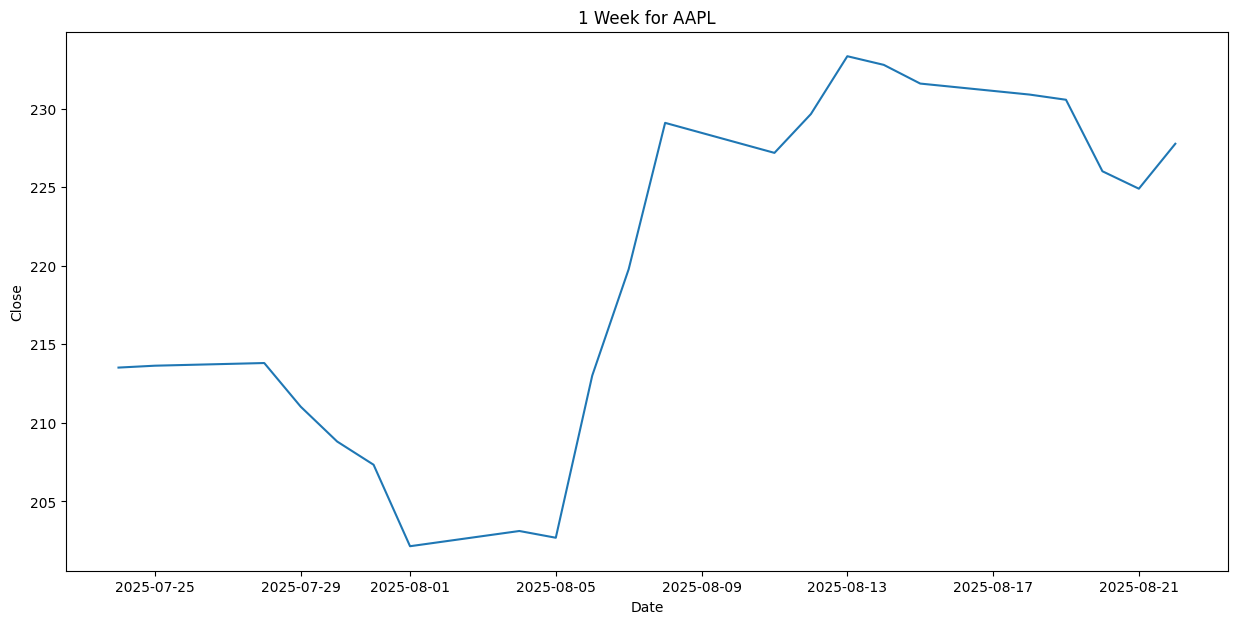

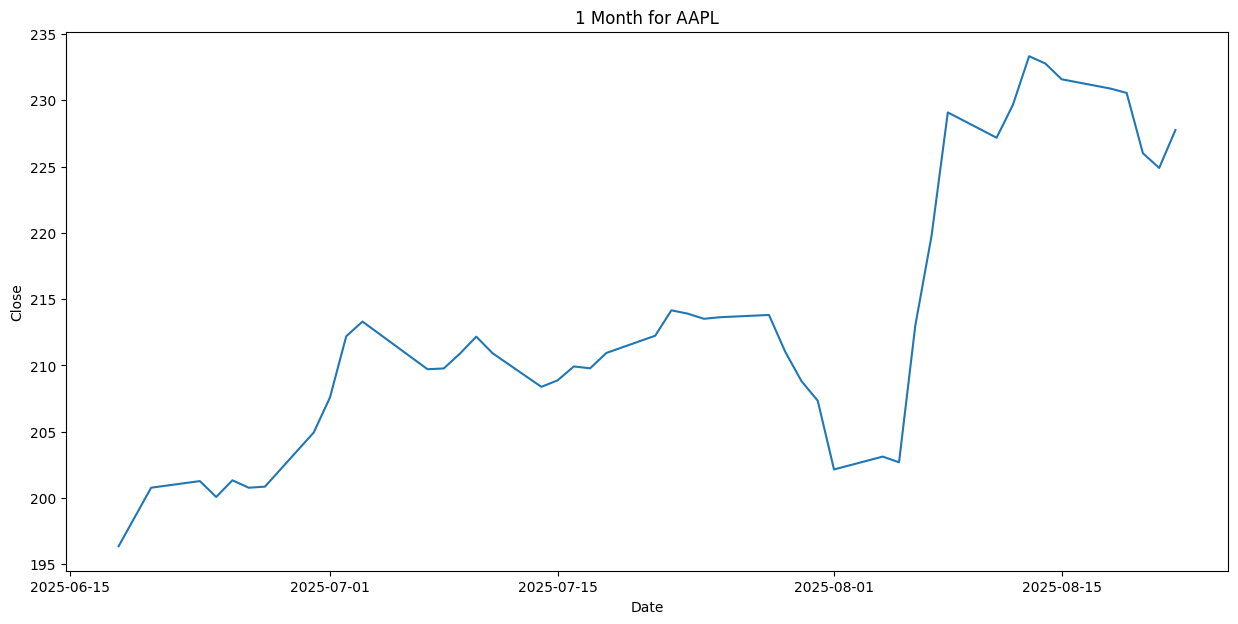

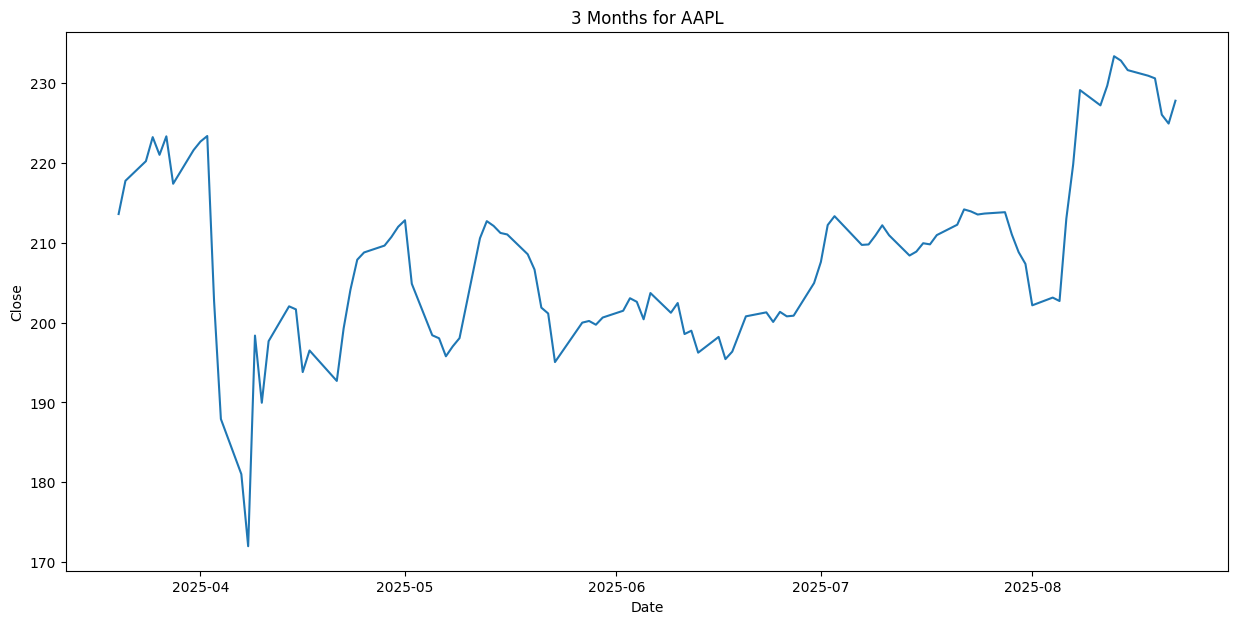

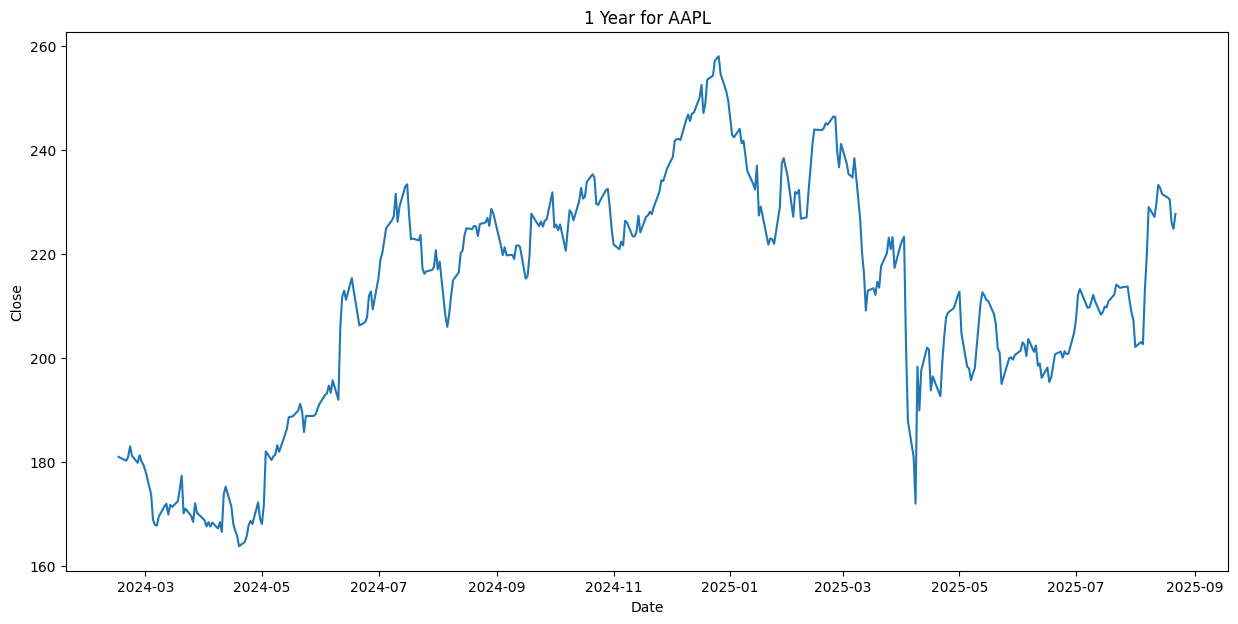

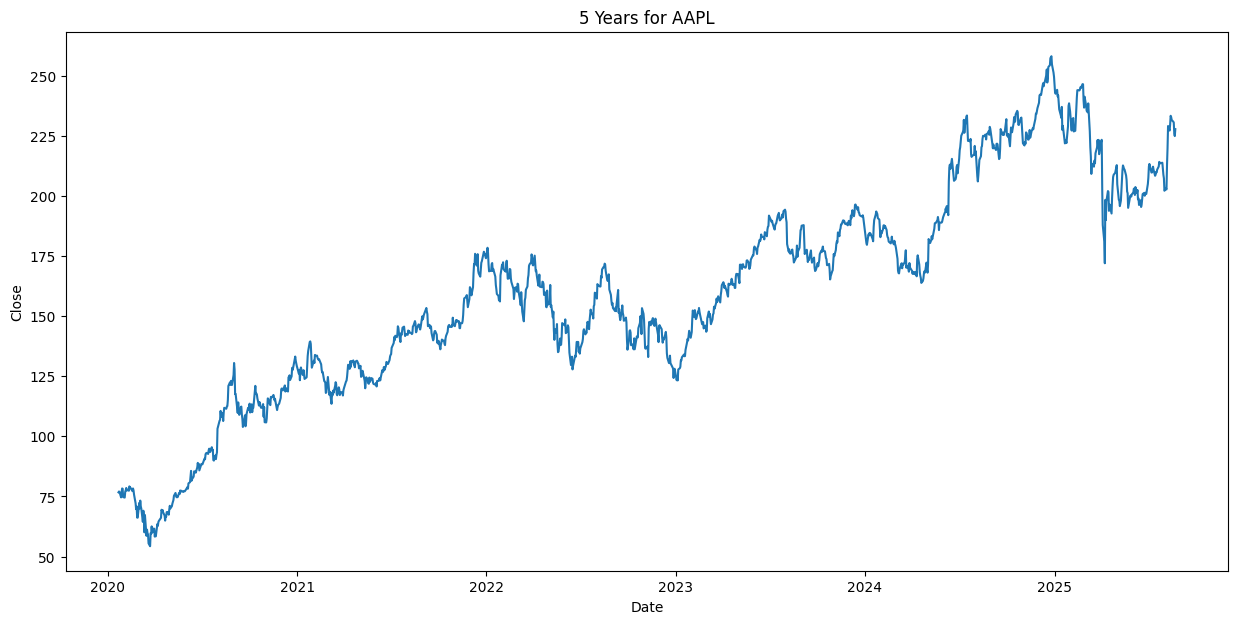

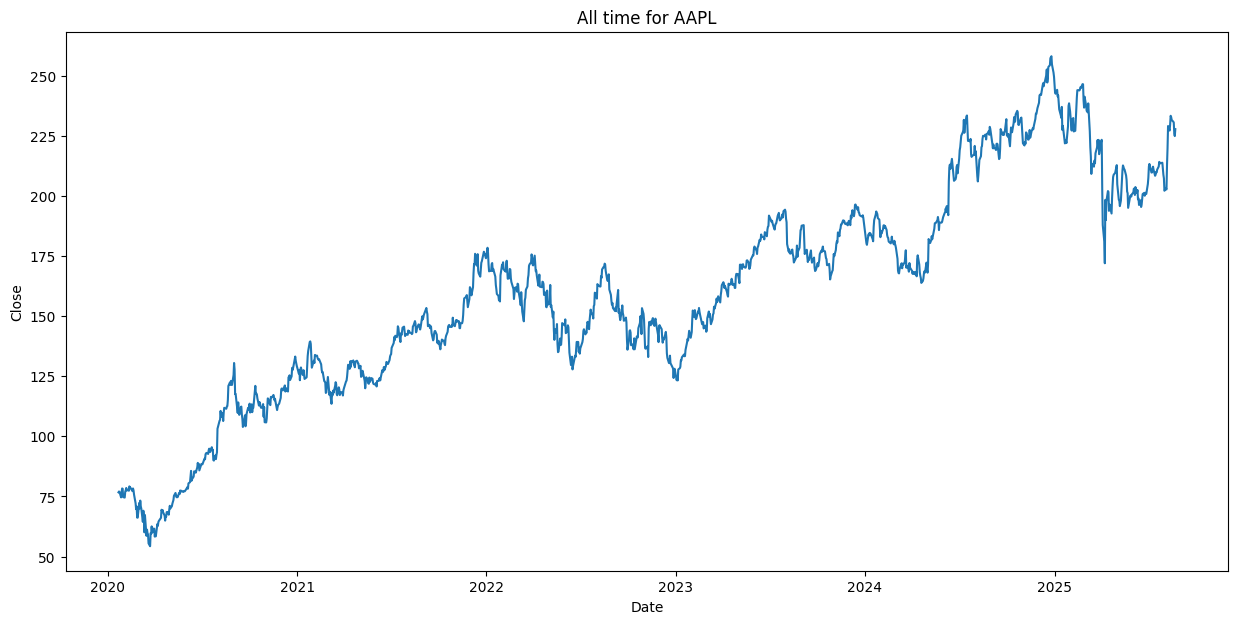

---------------------------------------------------------------------------
AMZN:
        Close       High        Low       Open    Volume       Date  \
15  94.373001  95.125000  94.167000  94.804497  64326000 2020-01-22   
16  94.228996  94.499001  93.638000  94.255501  49692000 2020-01-23   
17  93.082001  94.749496  92.372002  94.568497  75324000 2020-01-24   
18  91.417000  92.050003  90.766998  91.000000  70570000 2020-01-27   
19  92.662498  92.905502  91.500999  92.025002  56160000 2020-01-28   

    Price Change  Average Gain  Average Loss        RS        RSI  Short EMA  \
15     -0.226997      0.329679      0.367358  0.897434  47.297251  94.202401   
16     -0.144005      0.329679      0.377644  0.872990  46.609443  94.206492   
17     -1.146996      0.329679      0.377286  0.873818  46.633012  94.033494   
18     -1.665001      0.230001      0.496215  0.463510  31.671133  93.630956   
19      1.245499      0.304750      0.496215  0.614150  38.047881  93.481963   

     Long 

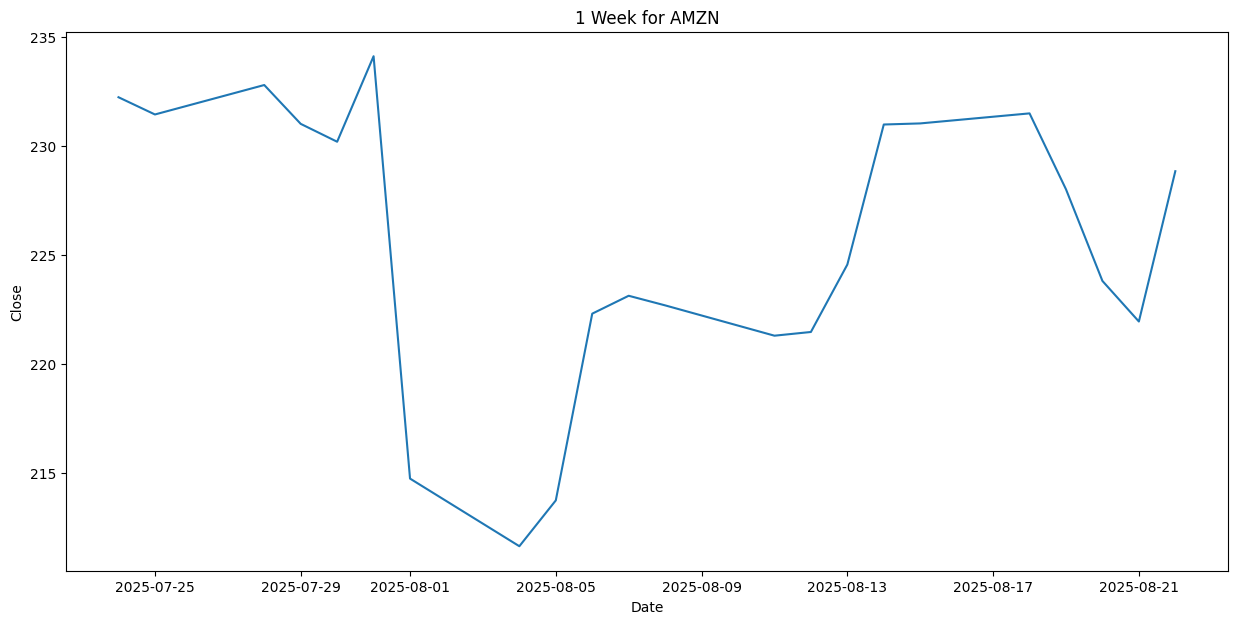

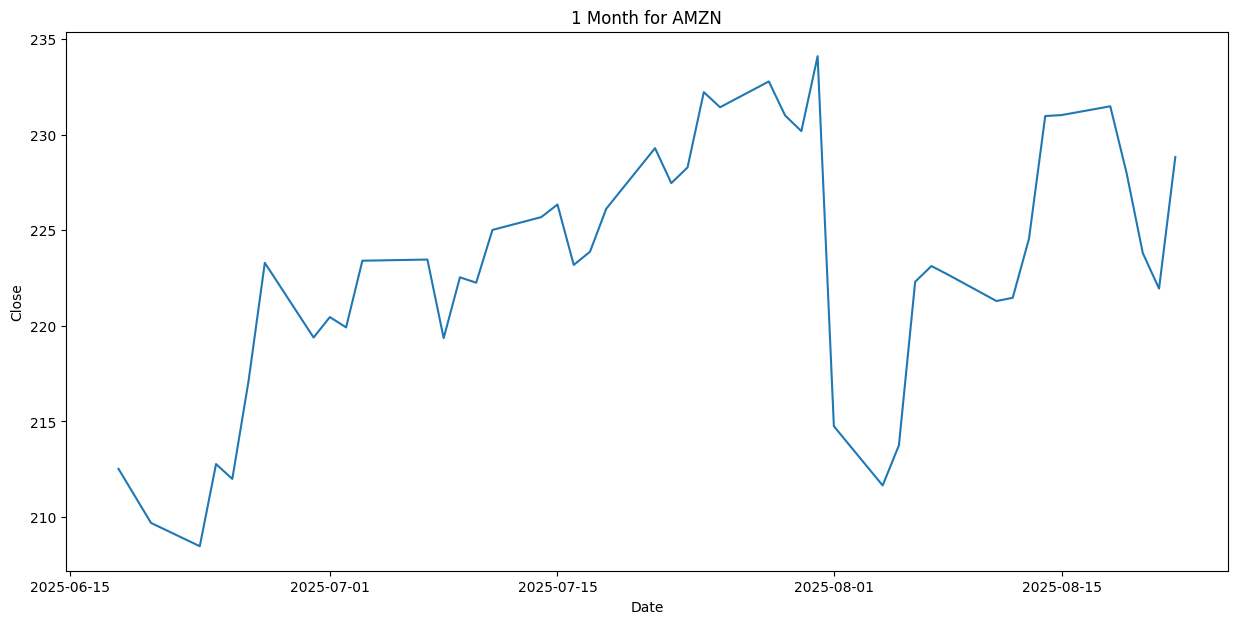

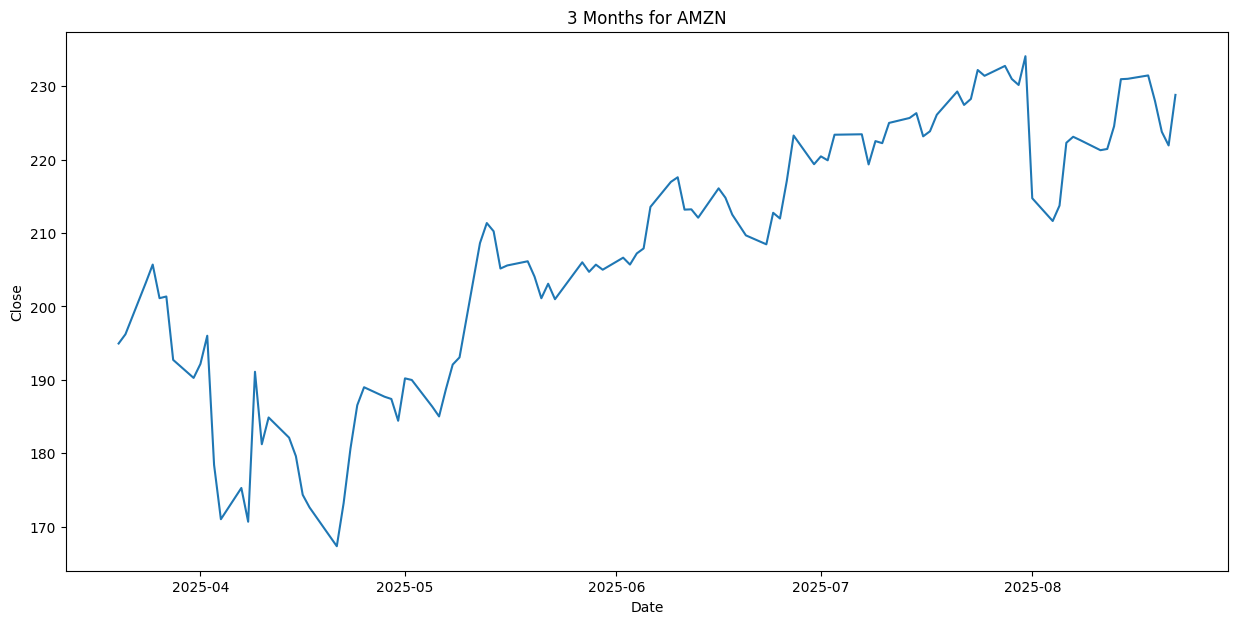

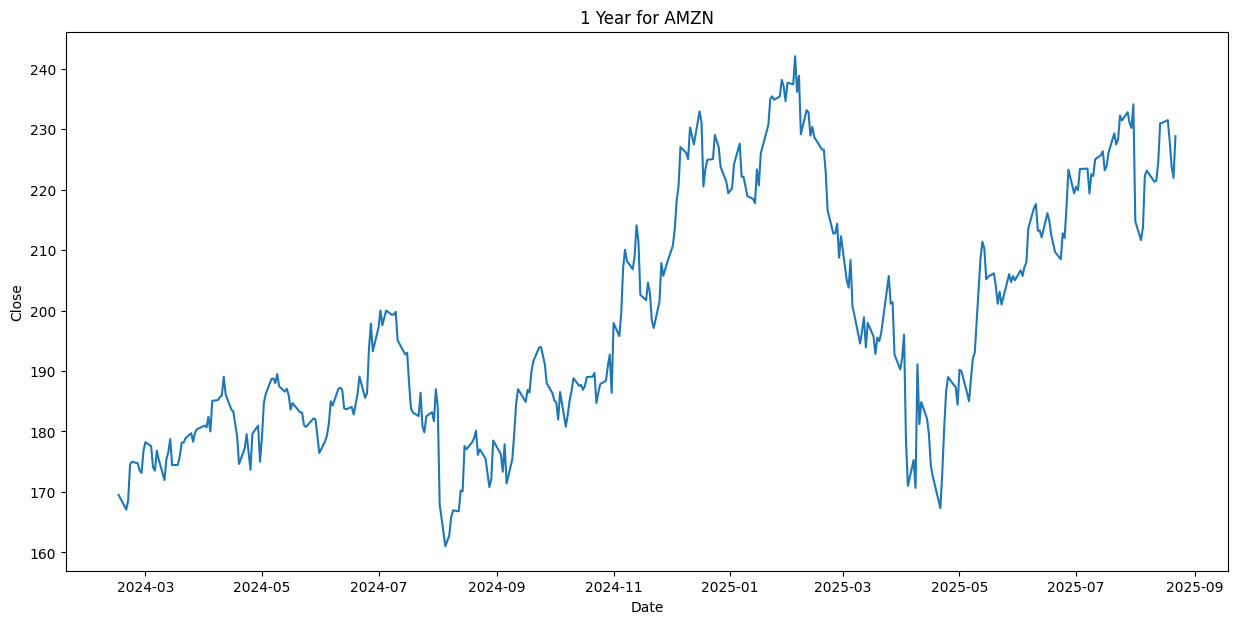

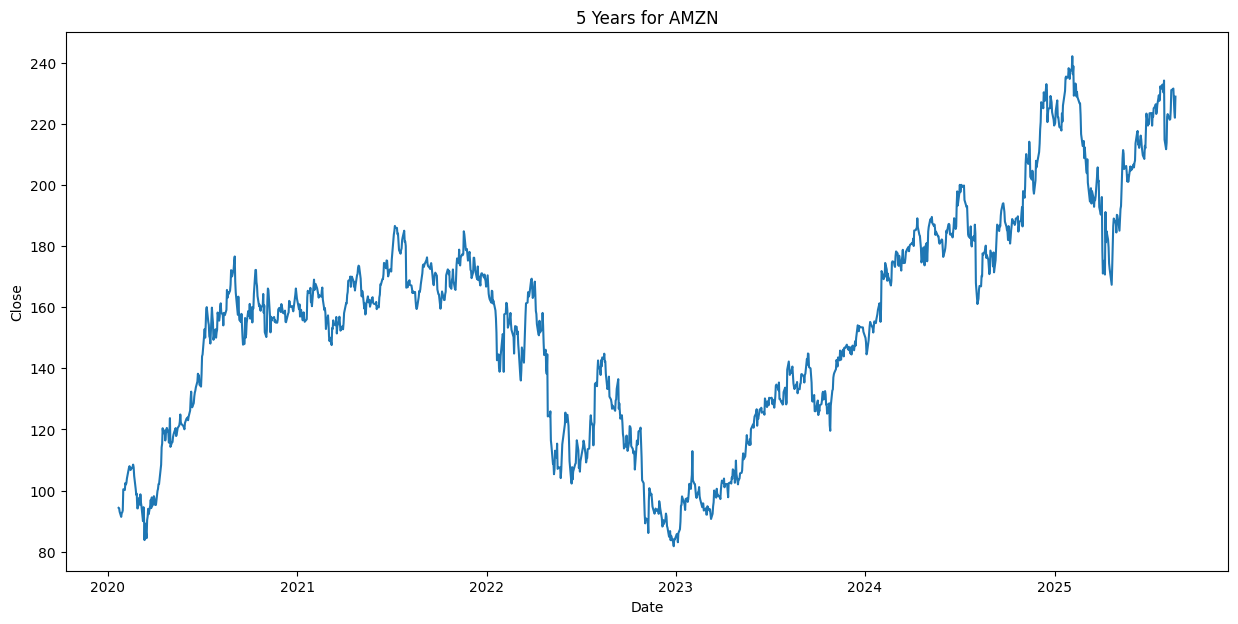

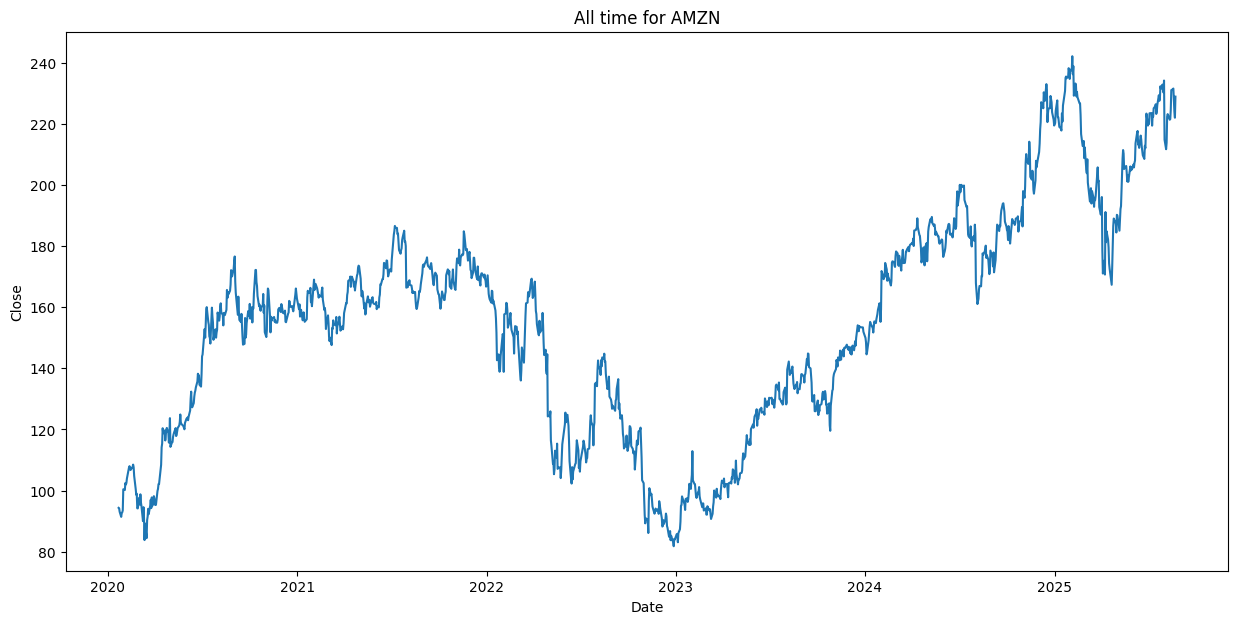

---------------------------------------------------------------------------
MSFT:
         Close        High         Low        Open    Volume       Date  \
15  157.623550  159.326311  157.604521  159.240687  24138800 2020-01-22   
16  158.593796  158.669898  157.214474  158.089630  19680800 2020-01-23   
17  156.995682  159.364320  156.434443  159.345291  24918100 2020-01-24   
18  154.370224  155.416614  152.391605  153.295297  32078100 2020-01-27   
19  157.395264  157.680630  155.121756  155.797142  24899900 2020-01-28   

    Price Change  Average Gain  Average Loss        RS        RSI   Short EMA  \
15     -0.761002      0.803808      0.458637  1.752603  63.670748  155.776377   
16      0.970245      0.873111      0.458637  1.903710  65.561297  156.209826   
17     -1.598114      0.873111      0.436893  1.998456  66.649500  156.330727   
18     -2.625458      0.845254      0.624426  1.353651  57.512809  156.029111   
19      3.025040      1.061328      0.525902  2.018111  66.866

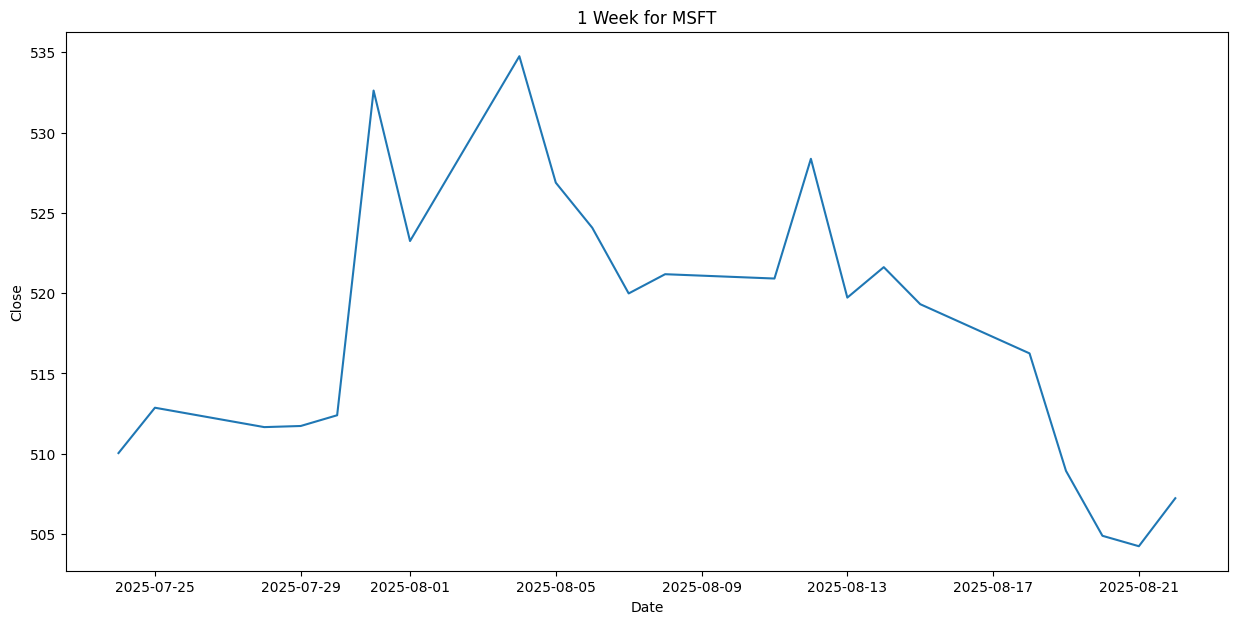

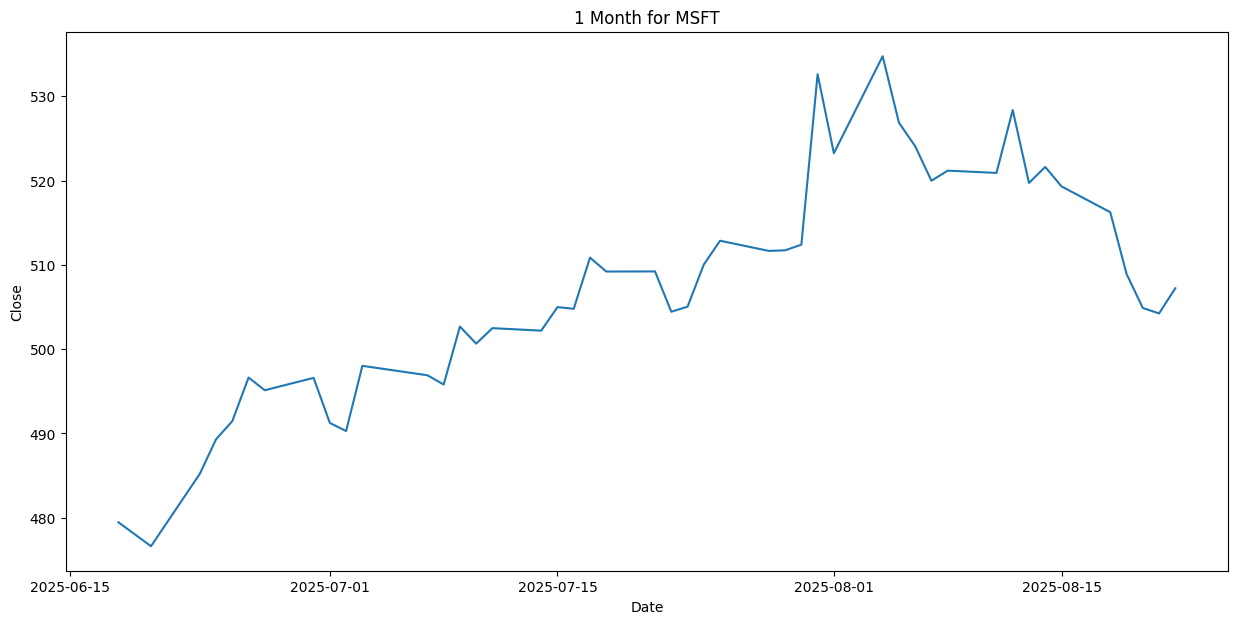

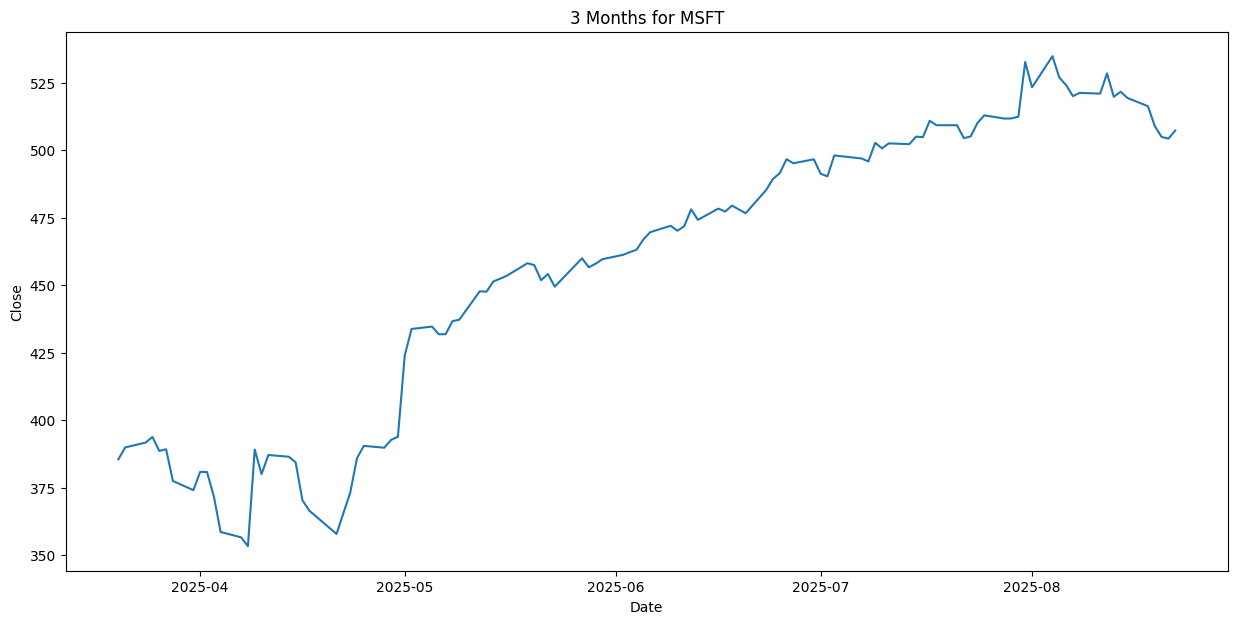

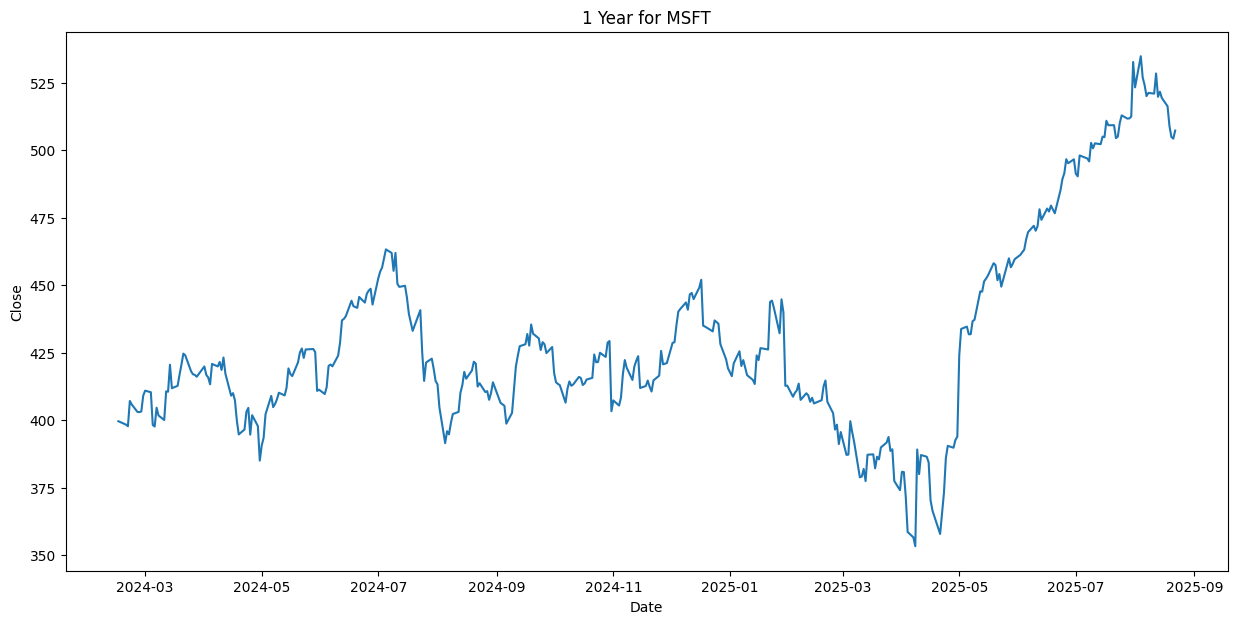

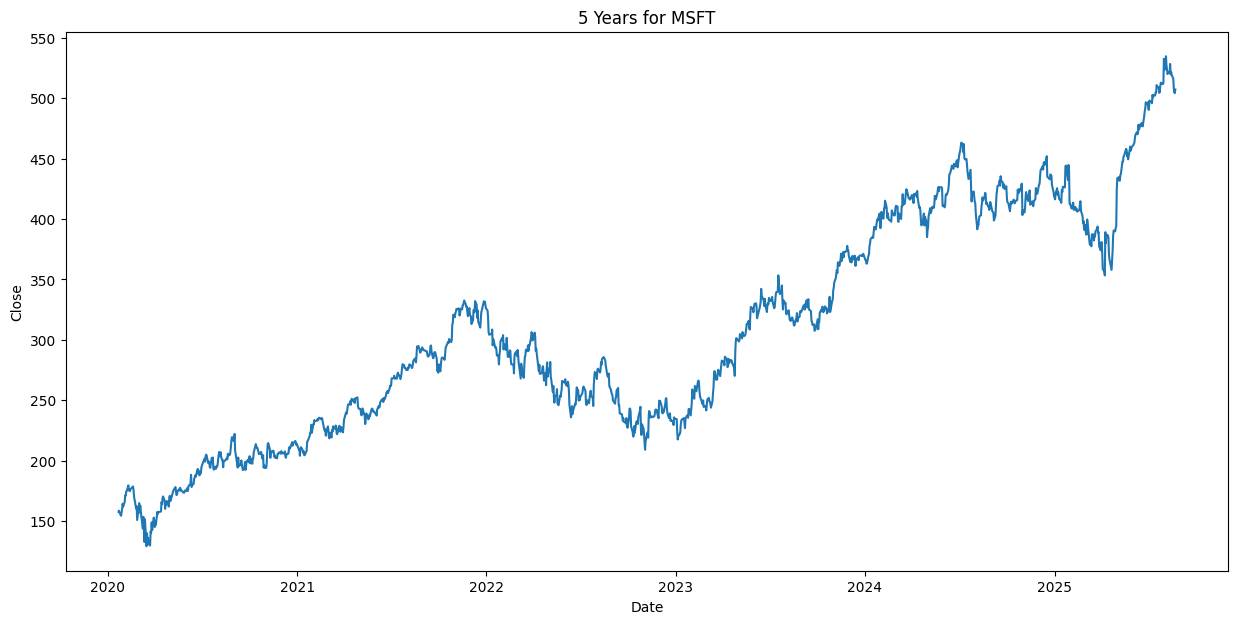

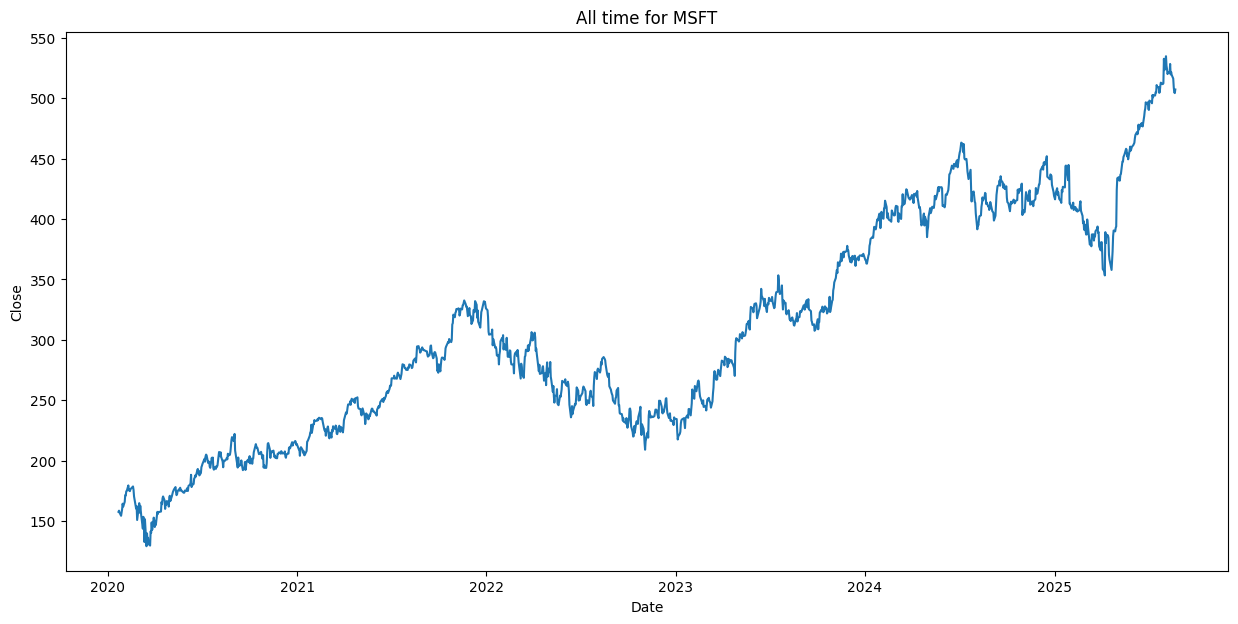

---------------------------------------------------------------------------
NVDA:
       Close      High       Low      Open     Volume       Date  \
15  6.225641  6.312263  6.198011  6.216929  239240000 2020-01-22   
16  6.294093  6.302556  6.176853  6.265717  244516000 2020-01-23   
17  6.234851  6.459373  6.180587  6.409590  373512000 2020-01-24   
18  5.978966  6.029994  5.780579  5.930178  470536000 2020-01-27   
19  6.172373  6.204732  5.991660  6.044928  310976000 2020-01-28   

    Price Change  Average Gain  Average Loss        RS        RSI  Short EMA  \
15      0.054014      0.038742      0.020607  1.880077  65.278701   6.128833   
16      0.068452      0.043631      0.020607  2.117352  67.921488   6.154257   
17     -0.059242      0.043631      0.018011  2.422506  70.781641   6.166656   
18     -0.255885      0.041871      0.036288  1.153849  53.571483   6.137781   
19      0.193408      0.050583      0.036288  1.393925  58.227589   6.143103   

    Long EMA      MACD  Sign

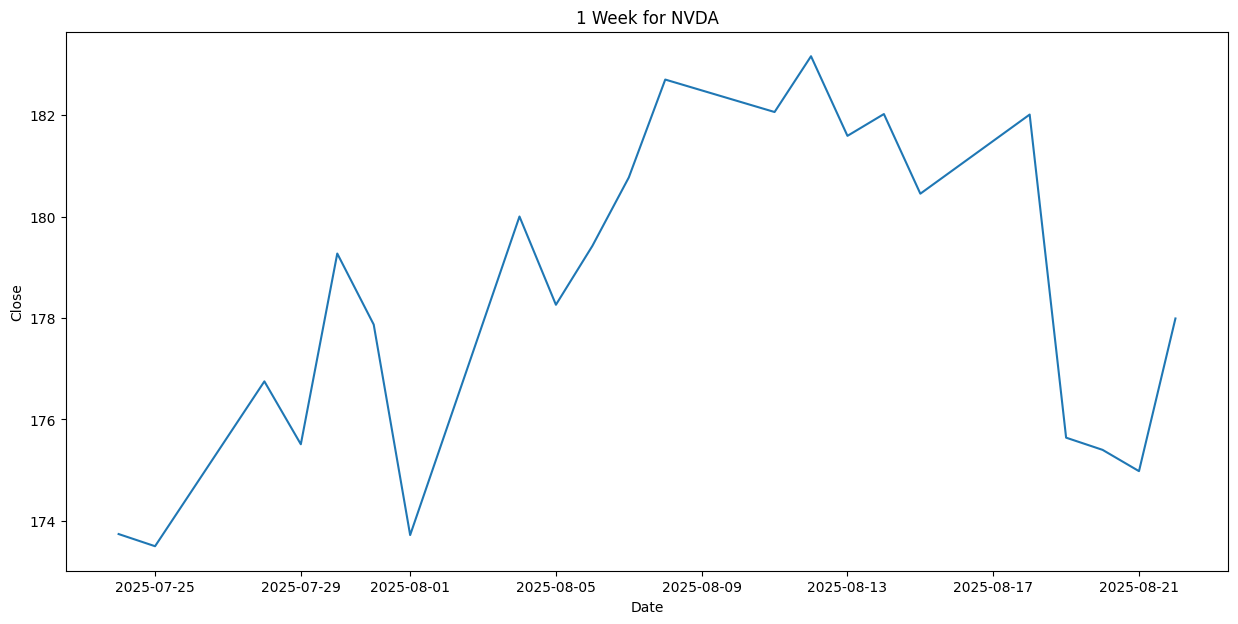

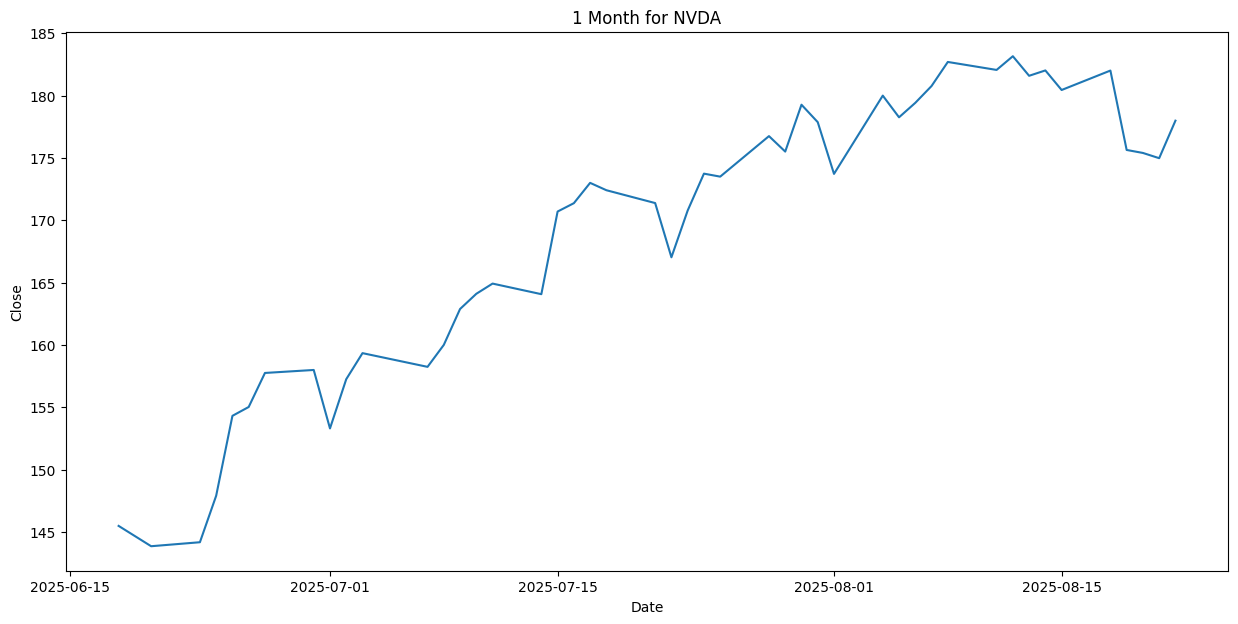

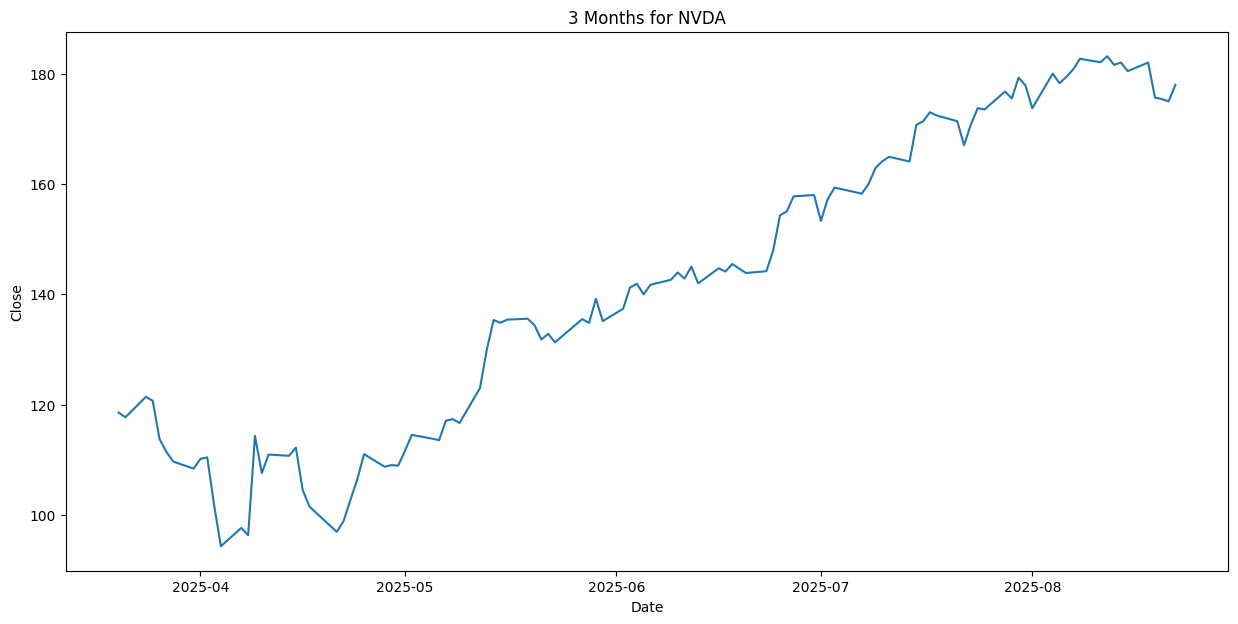

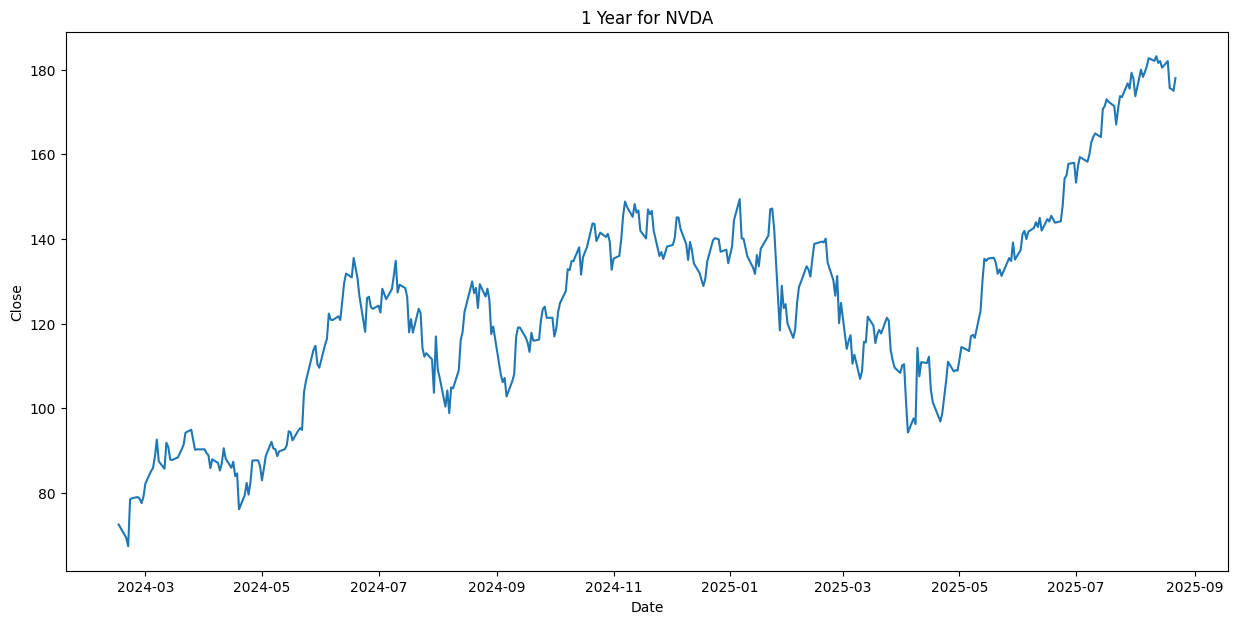

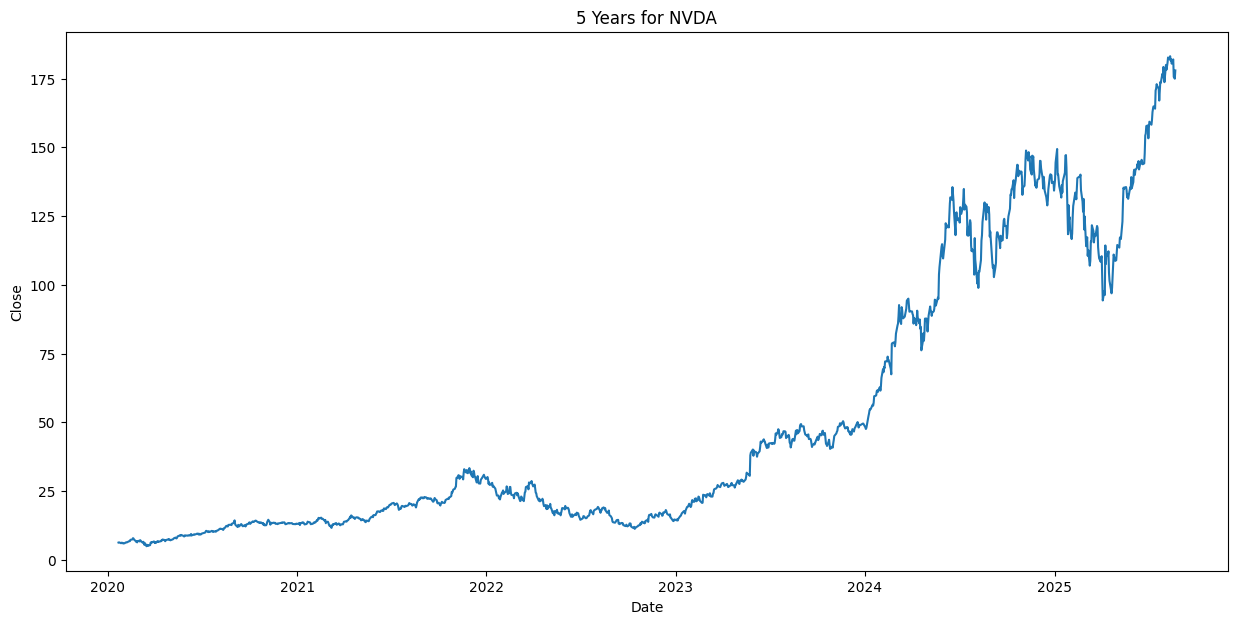

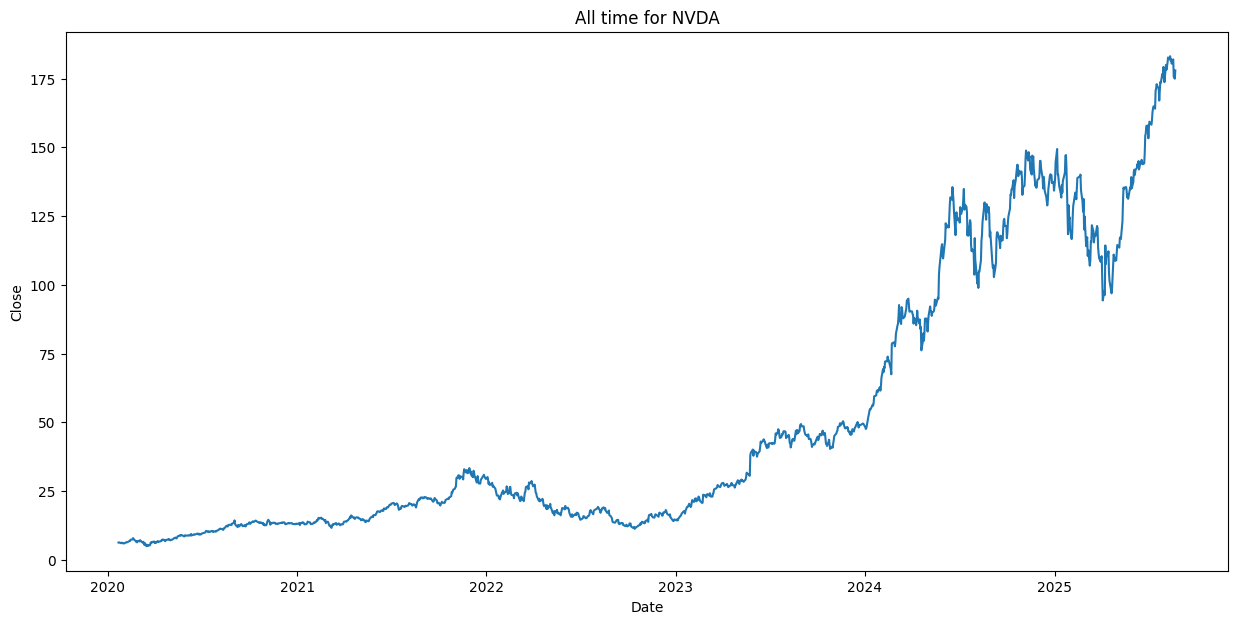

In [324]:
for i,df in enumerate(dfs):
    convert_type(df)
    df = engineer_features(df)
    df = drop_features_and_na(df)
    
    print('---------------------------------------------------------------------------')
    print(f"{stocks[i]}:")
    print(df.head())
    
    print_dmy_plots(df, stocks[i])
    # print_plots(df, stocks[i])